# 3. Рекомендательная система (20 баллов)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [0]:
import pandas as pd

In [91]:
colab = True
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [92]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Classroom/data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../../../../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head(10)

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534


In [93]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Classroom/data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../../../../data/anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных (1 балл)

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [95]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      12017 non-null  object 
 1   genre     12017 non-null  object 
 2   type      12017 non-null  object 
 3   episodes  12017 non-null  object 
 4   rating    12017 non-null  float64
 5   members   12017 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB


In [96]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [97]:
anime.isnull().sum()

name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [98]:
ratings.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### anime.type

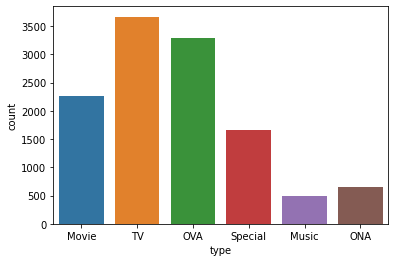

In [99]:
sns.countplot(anime.type);

#### anime.episodes

Для начала преобразуем в число и посмотрим на пропущенные значения

In [0]:
anime.episodes = pd.to_numeric(anime.episodes, errors='coerce')

In [101]:
anime.episodes.isnull().sum()

187

Посмотрим на пропущенные значения:

In [102]:
anime[anime.episodes.isna()].head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,NaN,8.58,504862
235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,NaN,8.25,114702
1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,NaN,7.94,533578
966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,NaN,7.73,26267
33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,NaN,7.72,5400


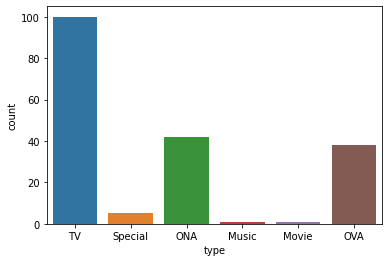

In [103]:
sns.countplot(anime[anime.episodes.isna()]['type']);

Вероятно фильмы еще не закончены и постоянно выпускаются новые эпизоды. Значений пропусков не много, да и суть задания не в этом, поэтому не стал париться, пропуски просто убрал, чтобы не мешались.

In [0]:
anime.dropna(axis=0,inplace=True)

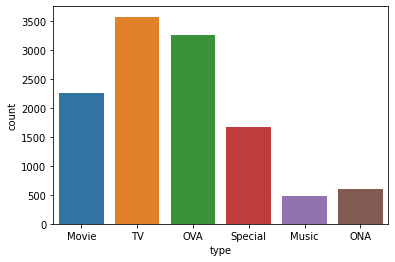

In [105]:
sns.countplot(anime['type']);

In [0]:
types = anime.type.unique()

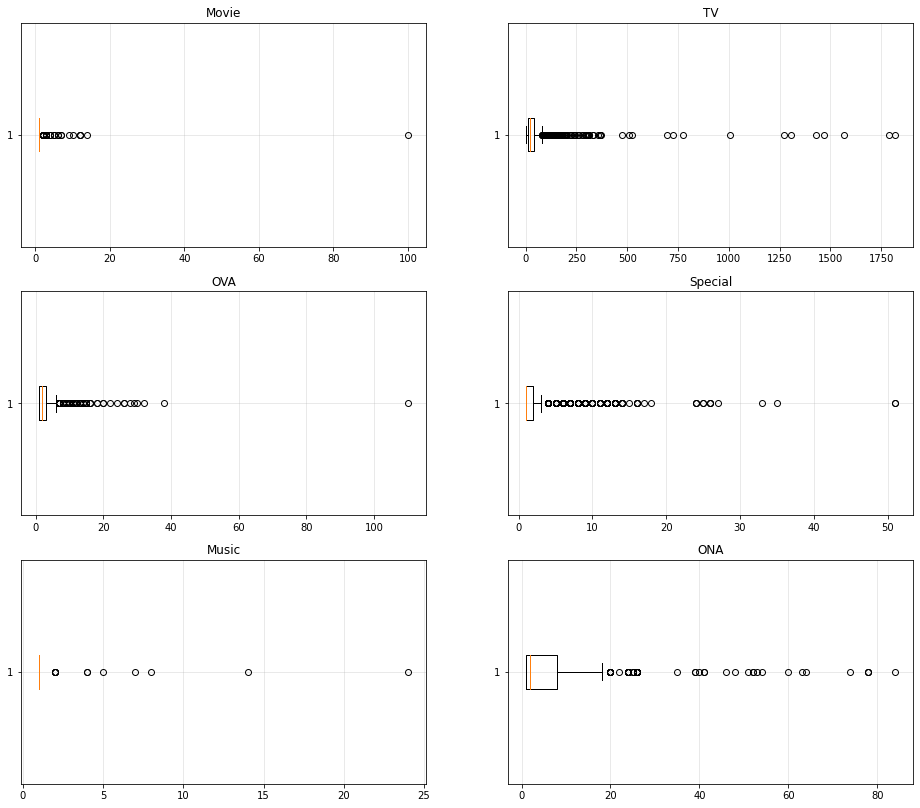

In [107]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))

i=0
for row, row_axes in enumerate(axes):
    for column, ax in enumerate(row_axes):
        ax.grid(alpha=0.35)
        x = anime[anime['type']==types[i]]['episodes']
        ax.boxplot(x,vert=False)
        ax.set_title(types[i])
        i+=1

#### anime.rating

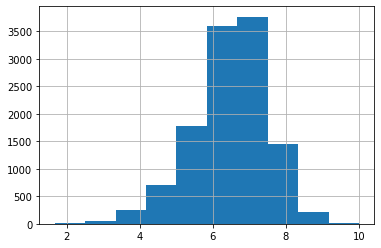

In [108]:
#Посмотрим н распределение рейтинга
anime.rating.hist();

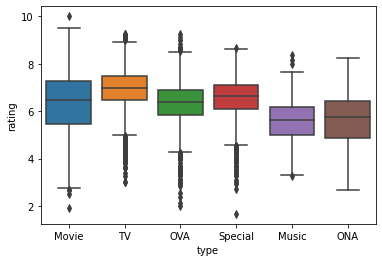

In [109]:
#Рейтинг в зависимости от категории фильма
sns.boxplot(data=anime,x='type',y='rating');

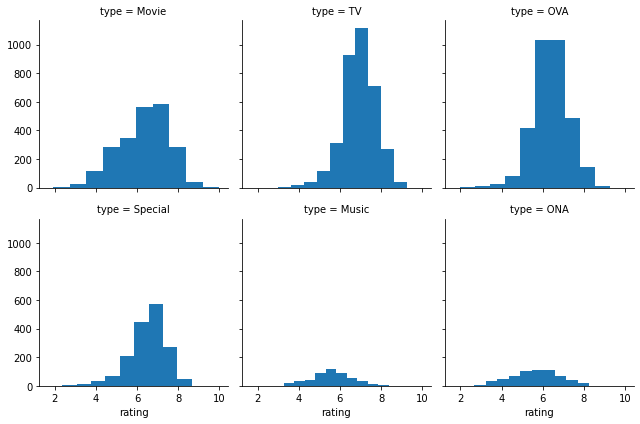

In [110]:
g = sns.FacetGrid(anime, col="type", col_wrap=3, height=3)
g.map(plt.hist, "rating");

In [111]:
anime.groupby('type')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
Movie,2258.0,6.334486,1.207021,1.92,5.45,6.49,7.260,10.00
Music,487.0,5.588665,0.959398,3.28,5.01,5.62,6.155,8.38
ONA,606.0,5.640479,1.125504,2.67,4.87,5.74,6.420,8.26
OVA,3246.0,6.371087,0.859524,2.00,5.85,6.37,6.910,9.25
Special,1665.0,6.525453,0.884138,1.67,6.09,6.63,7.110,8.66
TV,3568.0,6.929487,0.830774,3.00,6.47,6.96,7.470,9.26


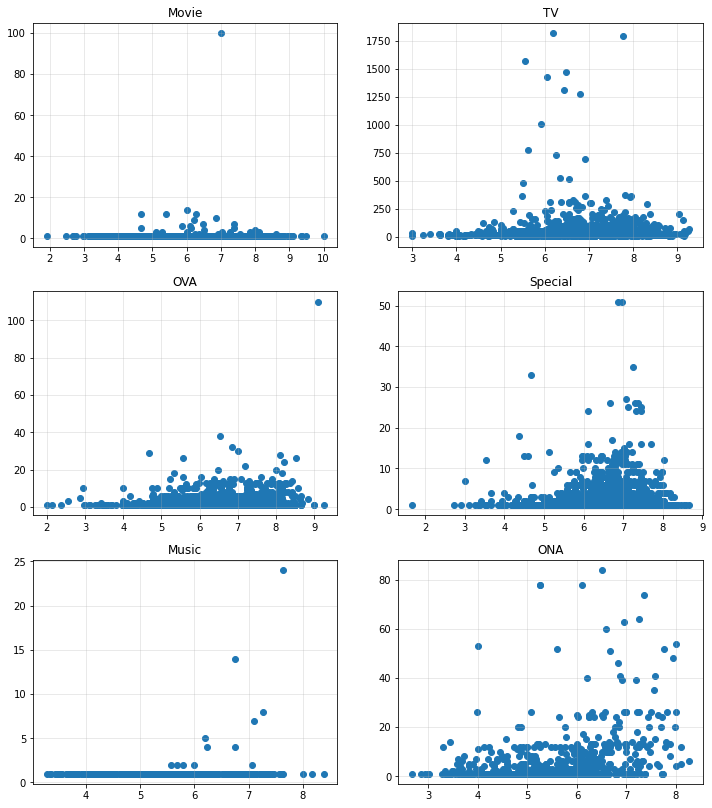

In [112]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

i=0
for row, row_axes in enumerate(axes):
    for column, ax in enumerate(row_axes):
        ax.grid(alpha=0.35)
        x = anime[anime['type']==types[i]]
        ax.scatter(data=x,x='rating',y='episodes')
        ax.set_title(types[i])
        i+=1

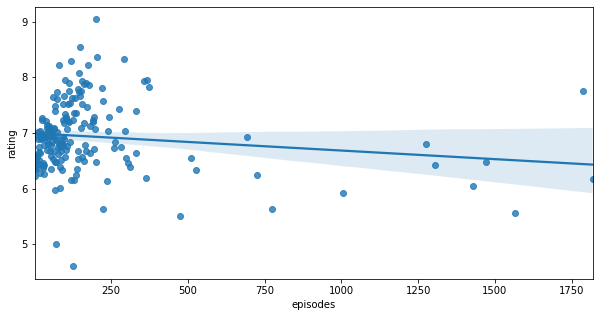

In [113]:
fsize = (10, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.regplot(data=anime.groupby('episodes')['rating'].mean().reset_index(),x='episodes',y='rating')

#### anime.members

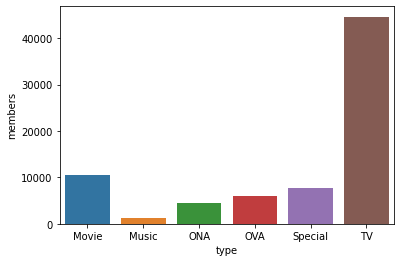

In [114]:
#Среднее количество подписчиков в зависимости от категории фаильма
sns.barplot(data=anime.groupby('type')['members'].mean().reset_index(),x='type',y='members');

Зависимости количества подписчиков от количества эпизодов не наблюдается:

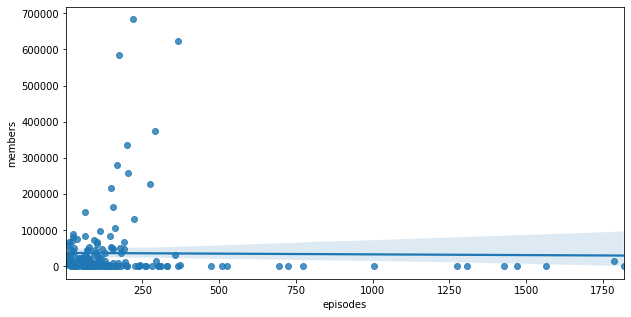

In [115]:
fsize = (10, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.regplot(data=anime.groupby('episodes')['members'].mean().reset_index(),x='episodes',y='members')

## Жанры (4 балла)

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

Определим все множество жанров:

In [0]:
g_list = [g for g in anime['genre'].str.split(', ')]

In [0]:
from itertools import chain

In [0]:
g_set = set(chain.from_iterable(g_list))

In [0]:
genres = list(g_set) 

In [120]:
genres

['Super Power',
 'Comedy',
 'Samurai',
 'Vampire',
 'Demons',
 'Mystery',
 'Josei',
 'Magic',
 'Horror',
 'Cars',
 'Historical',
 'Shoujo Ai',
 'Adventure',
 'Drama',
 'Supernatural',
 'Sci-Fi',
 'Slice of Life',
 'Space',
 'Sports',
 'Action',
 'Romance',
 'Kids',
 'Harem',
 'Ecchi',
 'Fantasy',
 'Shoujo',
 'Thriller',
 'Shounen Ai',
 'Yaoi',
 'Shounen',
 'Mecha',
 'Martial Arts',
 'Dementia',
 'Music',
 'Parody',
 'Psychological',
 'Military',
 'Police',
 'Hentai',
 'School',
 'Seinen',
 'Yuri',
 'Game']

Сделаю новую таблицу заполненную нулями, дальше будем проставлять 1 в нужных столбцах:

In [0]:
anime_genre = pd.DataFrame(0,index=anime.index,columns=g_set)

In [122]:
anime_genre.head()

,Super Power,Comedy,Samurai,Vampire,Demons,Mystery,Josei,Magic,Horror,Cars,Historical,Shoujo Ai,Adventure,Drama,Supernatural,Sci-Fi,Slice of Life,Space,Sports,Action,Romance,Kids,Harem,Ecchi,Fantasy,Shoujo,Thriller,Shounen Ai,Yaoi,Shounen,Mecha,Martial Arts,Dementia,Music,Parody,Psychological,Military,Police,Hentai,School,Seinen,Yuri,Game
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Проставляем еденицы в соответствующих жанрах всех аниме:

In [0]:
for i,r in anime.iterrows():
    for g in r['genre'].split(', '):
        if g is not None:
            anime_genre.loc[i][g] = 1

In [124]:
anime_genre.head()

,Super Power,Comedy,Samurai,Vampire,Demons,Mystery,Josei,Magic,Horror,Cars,Historical,Shoujo Ai,Adventure,Drama,Supernatural,Sci-Fi,Slice of Life,Space,Sports,Action,Romance,Kids,Harem,Ecchi,Fantasy,Shoujo,Thriller,Shounen Ai,Yaoi,Shounen,Mecha,Martial Arts,Dementia,Music,Parody,Psychological,Military,Police,Hentai,School,Seinen,Yuri,Game
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5114,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
28977,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9969,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


Посмотрим графически на количество жанров:

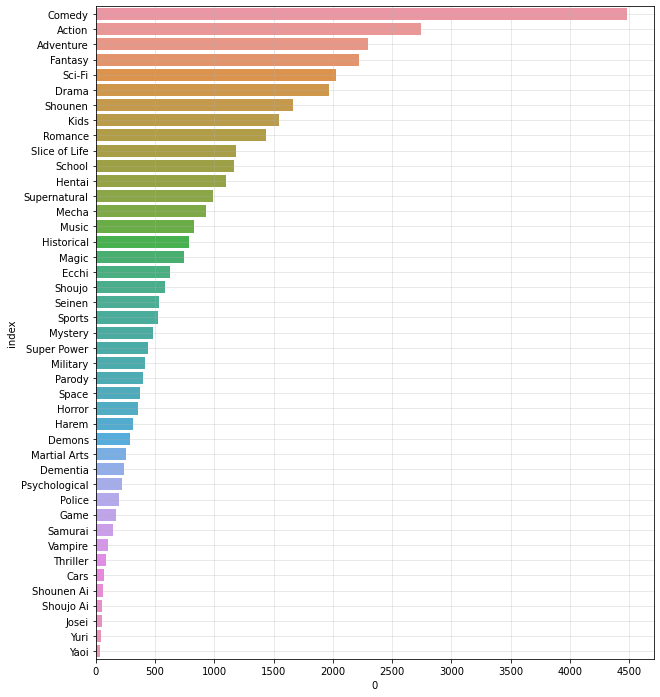

In [125]:
fsize = (10, 12)
fig, ax = plt.subplots(figsize=fsize)
sns.barplot(y='index',x=0, data=anime_genre.agg(sum).reset_index().sort_values(by=0,ascending=False))
plt.xticks(range(0, 5000, 500))
plt.grid(alpha=0.35)

Посмотрим на распределение рейтинга каждого из жанров:

In [126]:
#Будем считать, что рейтинг из таблиц anime и ratings совпадают
animeid=5114
print("Rate anime_id {}: ratings={}, anime={}".format(animeid,\
       ratings[(ratings['anime_id']==animeid) & (ratings['rating'] != -1)].rating.mean(),\
       anime.loc[animeid]['rating'])
     )

Rate anime_id 5114: ratings=9.32274123011073, anime=9.26


In [0]:
anime_genre_rate = anime_genre.multiply(anime['rating'], axis='index')

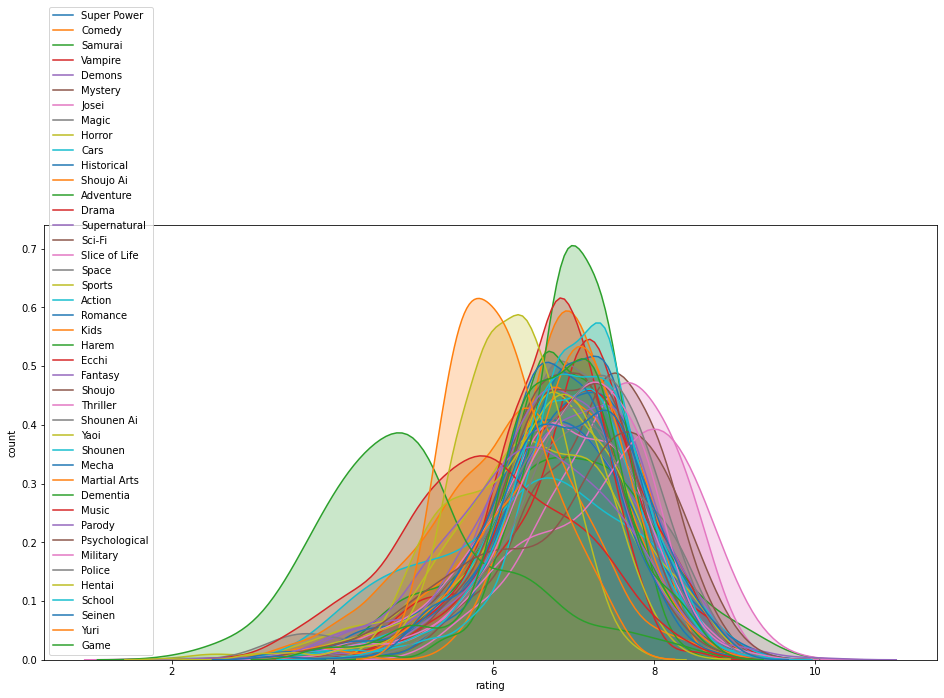

In [212]:
fsize = (16, 8)
fig, ax = plt.subplots(figsize=fsize)
for col in anime_genre_rate.columns:
  sns.kdeplot(anime_genre_rate[anime_genre_rate[col]>0][col],shade=True,label=col)
ax.set_xlabel('rating')
ax.set_ylabel('count')
plt.show()

In [0]:
sns.kdeplot?

## Рейтинг (1 балл)

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

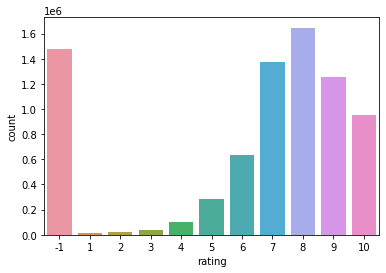

In [141]:
sns.countplot(ratings['rating']);

## Фильтрация данных (5 баллов)

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [142]:
anime.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [143]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Строю датафрейм anime_watches, где индексом является anime_name, а значением - количество его обзоров

In [0]:
anime_count_rew = ratings[ratings['rating'] != -1].groupby('anime_id')['rating'].count().rename('watches').reset_index()

In [145]:
anime_count_rew.head()

,anime_id,watches
0,1,13449
1,5,5790
2,6,9385
3,7,2169
4,8,308


In [146]:
print(anime.shape, anime_count_rew.shape)

(11830, 6) (9927, 2)


In [0]:
anime_watches = pd.merge(anime['name'],anime_count_rew, on='anime_id',how='left').set_index(anime.name).drop(['name'],axis=1)

In [148]:
anime_watches.shape

(11830, 2)

In [149]:
anime_watches.head()

,anime_id,watches
name,,
Kimi no Na wa.,32281,1961.0
Fullmetal Alchemist: Brotherhood,5114,21494.0
Gintama°,28977,1188.0
Steins;Gate,9253,17151.0
Gintama&#039;,9969,3115.0


In [0]:
#dropna

In [150]:
#Проверяем что просмотры смерджились верно
animeid=5114
print("watches anime_id {}: ratings={}, anime_watches={}".format(animeid,\
       ratings[(ratings['anime_id']==animeid) & (ratings['rating'] != -1)].rating.count(),\
       anime_watches[anime_watches['anime_id']==animeid]['watches'].values[0])
     )

watches anime_id 5114: ratings=21494, anime_watches=21494.0


In [151]:
#Пропуски тут говорят о том, что эти аниме не оценивались
anime_watches.isnull().sum()

anime_id       0
watches     1940
dtype: int64

user_ratings, где индексом является user_id, а значением - количество аниме, которое он оценил

In [0]:
user_ratings = ratings[ratings['rating'] != -1].groupby('user_id')['anime_id'].count().rename('reviews').reset_index().set_index('user_id')

Соединю 4 таблицы: ratings, anime, anime_watches, user_ratings

In [153]:
print('Shape ratings:{} ,anime: {}, anime_watches:{} ,user_ratings:{}'.\
      format(ratings.shape,anime.shape,anime_watches.shape,user_ratings.shape))

Shape ratings:(7813737, 3) ,anime: (11830, 6), anime_watches:(11830, 2) ,user_ratings:(69600, 1)


In [0]:
anime_ratings = ratings.join(anime,lsuffix='_user',on='anime_id')

In [0]:
anime_ratings = anime_ratings.join(anime_watches,rsuffix='_duble',on='name').drop('anime_id_duble', axis=1)

In [0]:
anime_ratings = anime_ratings.join(user_ratings,on='user_id')

In [172]:
anime_ratings.shape

(7813740, 11)

In [157]:
anime_ratings.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members,watches,reviews
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297.0,22071.0,4.0
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553.0,5980.0,4.0
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772.0,5856.0,4.0
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511.0,23528.0,4.0
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395.0,3365.0,4.0


"-1" означает, что этим конкретным пользователем конкретный фильм(аниме) не оценивался.

Заменю "-1" средний рейтинг аниме

In [0]:
rating_mean = int(anime_ratings['rating'].mean())

In [0]:
anime_ratings.loc[anime_ratings['rating_user']==-1,'rating_user'] = rating_mean

In [169]:
anime_ratings.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members,watches,reviews
0,1,20,7,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297.0,22071.0,4.0
1,1,24,7,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553.0,5980.0,4.0
2,1,79,7,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772.0,5856.0,4.0
3,1,226,7,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511.0,23528.0,4.0
4,1,241,7,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395.0,3365.0,4.0


Удаляю из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения.

In [0]:
watches_med = anime_ratings['watches'].median()

In [0]:
reviews_med = anime_ratings['reviews'].median()

In [0]:
anime_ratings = anime_ratings.drop((anime_ratings[(anime_ratings['watches']<watches_med) | (anime_ratings['reviews']<reviews_med)]).index,axis=0)

In [218]:
anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1757649 entries, 250 to 7813731
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   anime_id     int64  
 2   rating_user  int64  
 3   name         object 
 4   genre        object 
 5   type         object 
 6   episodes     float64
 7   rating       float64
 8   members      float64
 9   watches      float64
 10  reviews      float64
dtypes: float64(5), int64(3), object(3)
memory usage: 160.9+ MB


In [219]:
anime_ratings.isnull().sum()

user_id             0
anime_id            0
rating_user         0
name              118
genre             118
type              118
episodes          118
rating            118
members           118
watches          1463
reviews        186131
dtype: int64

## Матрица user-item (3 балла)

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [0]:
#piwot table

#numpy sparse matrix

In [0]:
import scipy.sparse as sps

In [188]:
sps.coo_matrix((anime_ratings['rating'], (anime_ratings['user_id'], anime_ratings['name'])))

TypeError: ignored

In [0]:
anime_ratings_matrix = sps.coo_matrix((anime_ratings['rating'], (anime_ratings['user_id'], anime_ratings['anime_id'])))

In [0]:
#memory

In [0]:
anime_ratings = pd.pivot_table(anime_ratings, values = 'rating_user', index=['user_id'], columns=['name'], aggfunc=np.sum)

## Понижение размерности (1 балл)

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [199]:
anime_ratings_matrix

<73516x34520 sparse matrix of type '<class 'numpy.float64'>'
	with 3389744 stored elements in COOrdinate format>

In [200]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4, random_state=42)

X_reduced = pca.fit_transform(anime_ratings_matrix)

TypeError: ignored

In [203]:
from sklearn.decomposition import TruncatedSVD
clf = TruncatedSVD(n_components=4)
Xpca = clf.fit_transform(anime_ratings_matrix)

ValueError: ignored

## Обучение kMeans (1 балл)

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

In [0]:
from sklearn.cluster import KMeans

In [0]:
#Нужно отмасштабировать признаки, т.к. Kmeans лучше подавать на вход данные одного масштаба
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) 

clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(df))

In [0]:
#силуэт кластера

## Top 15 аниме (2 балла)

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

## Top 5 жанров (2 балла)

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???